In [1]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!cd "/content/drive/My Drive/data"; ls -l

total 584768
-rw------- 1 root root 133047193 Mar  1 05:55 fashion-mnist_train.csv
-rw------- 1 root root 337809843 Feb 23 04:01 mercari_train.tsv
-rw------- 1 root root  18303650 Feb 26 09:13 mnist_test.csv
-rw------- 1 root root 109640201 Feb 26 09:14 mnist_train.csv


In [0]:
%matplotlib inline
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [0]:
class FashionMNIST(Dataset):
    def __init__(self, transform=None):
        self.transform = transform
        fashion_df = pd.read_csv('/content/drive/My Drive/data/fashion-mnist_train.csv')
        self.labels = fashion_df.label.values
        self.images = fashion_df.iloc[:, 1:].values.astype('uint8').reshape(-1, 28, 28)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        label = self.labels[idx]
        img = Image.fromarray(self.images[idx])
        
        if self.transform:
            img = self.transform(img)

        return img, label

In [5]:
dataset = FashionMNIST()
dataset.images.shape

(60000, 28, 28)

In [0]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, ), std=(0.5, ))
])
dataset = FashionMNIST(transform=transform)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)


In [0]:
# 구분자 생성
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(794, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels):
        x = x.view(x.size(0), 784)
        c = self.label_emb(labels)
        x = torch.cat([x, c], 1)
        out = self.model(x)
        return out.squeeze()

In [0]:
# 생성자 생성
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(110, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        z = z.view(z.size(0), 100)
        c = self.label_emb(labels)
        x = torch.cat([z, c], 1)
        out = self.model(x)
        return out.view(x.size(0), 28, 28)

In [0]:
generator = Generator().cuda()
discriminator = Discriminator().cuda()

In [0]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4)

In [0]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    g_optimizer.zero_grad()
    z = Variable(torch.randn(batch_size, 100)).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
    fake_images = generator(z, fake_labels)
    validity = discriminator(fake_images, fake_labels)
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).cuda())
    g_loss.backward()
    g_optimizer.step()
    return g_loss.data

In [0]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    d_optimizer.zero_grad()

    # train with real images
    real_validity = discriminator(real_images, labels)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).cuda())
    
    # train with fake images
    z = Variable(torch.randn(batch_size, 100)).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
    fake_images = generator(z, fake_labels)
    fake_validity = discriminator(fake_images, fake_labels)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).cuda())
    
    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss.data

Starting epoch 0...
g_loss: 3.051201820373535, d_loss: 0.6987299919128418


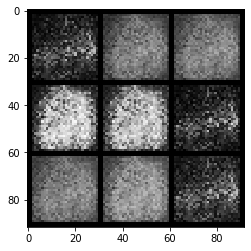

Starting epoch 1...
g_loss: 5.039343357086182, d_loss: 0.2949504256248474


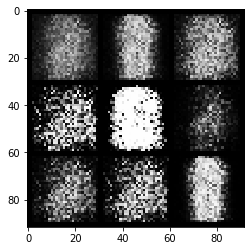

Starting epoch 2...
g_loss: 4.278733253479004, d_loss: 0.1288231909275055


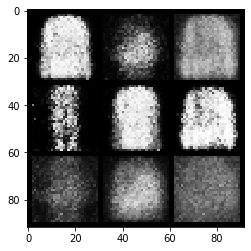

Starting epoch 3...
g_loss: 2.5679726600646973, d_loss: 0.598499059677124


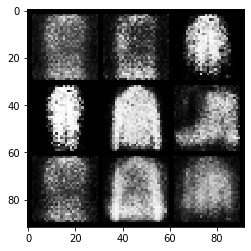

Starting epoch 4...
g_loss: 2.669585943222046, d_loss: 0.31867265701293945


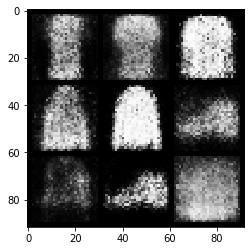

Starting epoch 5...
g_loss: 2.333343505859375, d_loss: 0.599003255367279


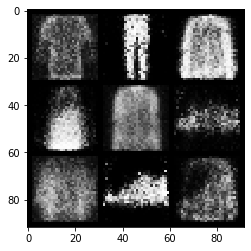

Starting epoch 6...
g_loss: 2.083174228668213, d_loss: 0.53775554895401


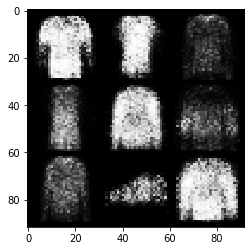

Starting epoch 7...
g_loss: 1.5664889812469482, d_loss: 0.9708189368247986


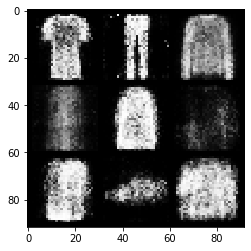

Starting epoch 8...
g_loss: 2.2902188301086426, d_loss: 0.712553858757019


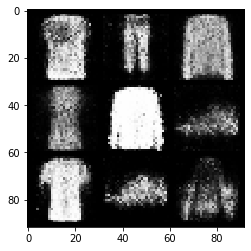

Starting epoch 9...
g_loss: 1.9492303133010864, d_loss: 0.8661874532699585


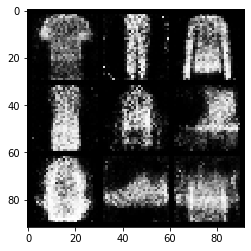

Starting epoch 10...
g_loss: 1.578067660331726, d_loss: 0.8351402878761292


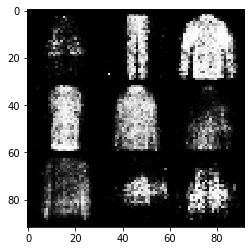

Starting epoch 11...
g_loss: 1.6666326522827148, d_loss: 1.0837286710739136


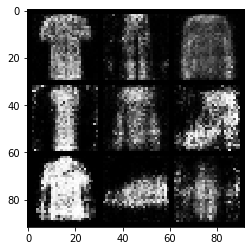

Starting epoch 12...
g_loss: 2.0204973220825195, d_loss: 0.903894305229187


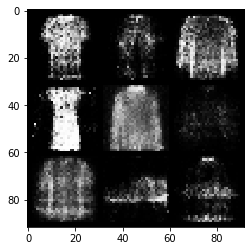

Starting epoch 13...
g_loss: 1.4112279415130615, d_loss: 1.2107536792755127


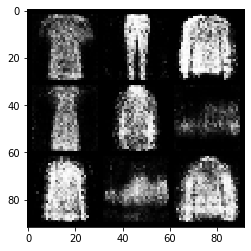

Starting epoch 14...
g_loss: 1.3382209539413452, d_loss: 0.9083840847015381


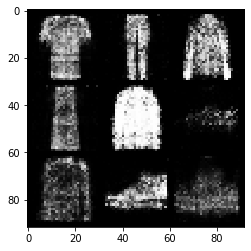

Starting epoch 15...
g_loss: 1.6409800052642822, d_loss: 0.8757987022399902


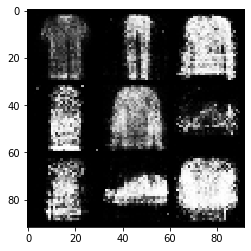

Starting epoch 16...
g_loss: 1.1393202543258667, d_loss: 1.0397285223007202


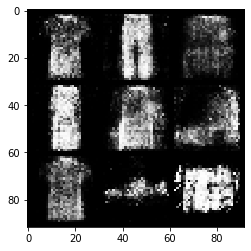

Starting epoch 17...
g_loss: 1.4736310243606567, d_loss: 1.1207988262176514


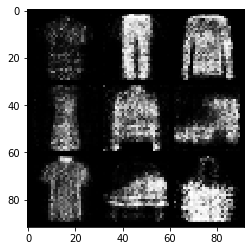

Starting epoch 18...
g_loss: 1.3287603855133057, d_loss: 0.8358684182167053


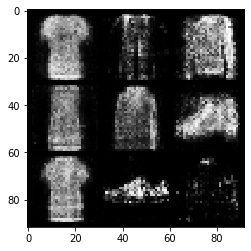

Starting epoch 19...
g_loss: 1.7660982608795166, d_loss: 1.055416226387024


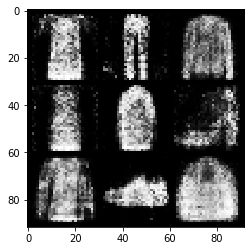

Starting epoch 20...
g_loss: 1.4204940795898438, d_loss: 1.3874130249023438


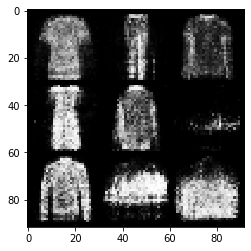

Starting epoch 21...
g_loss: 1.203751564025879, d_loss: 0.9843010902404785


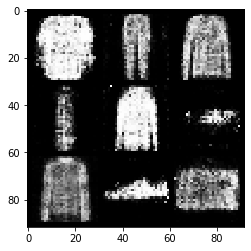

Starting epoch 22...
g_loss: 1.2455891370773315, d_loss: 0.8570608496665955


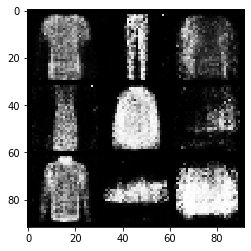

Starting epoch 23...
g_loss: 1.3699063062667847, d_loss: 1.0113556385040283


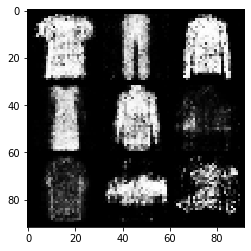

Starting epoch 24...
g_loss: 1.070580005645752, d_loss: 1.0296220779418945


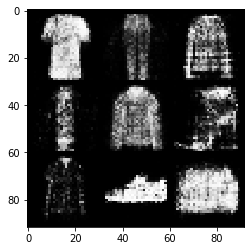

Starting epoch 25...
g_loss: 1.2540006637573242, d_loss: 1.1364655494689941


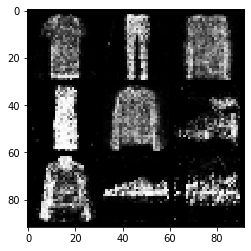

Starting epoch 26...
g_loss: 1.1042628288269043, d_loss: 1.131070613861084


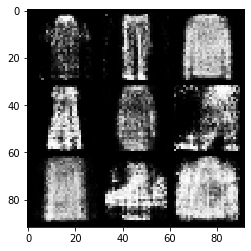

Starting epoch 27...
g_loss: 1.1457433700561523, d_loss: 0.9162492156028748


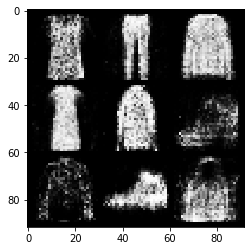

Starting epoch 28...
g_loss: 1.352760910987854, d_loss: 1.3142627477645874


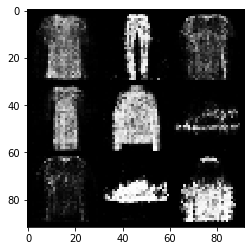

Starting epoch 29...
g_loss: 0.9445160627365112, d_loss: 1.2922329902648926


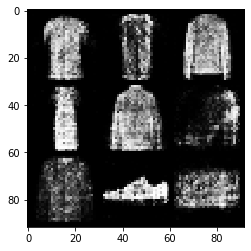

In [22]:
num_epochs = 30
n_critic = 5
display_step = 300
for epoch in range(num_epochs):
    print('Starting epoch {}...'.format(epoch))
    for i, (images, labels) in enumerate(data_loader):
        real_images = Variable(images).cuda()
        labels = Variable(labels).cuda()
        generator.train()
        batch_size = real_images.size(0)
        d_loss = discriminator_train_step(len(real_images), discriminator,
                                          generator, d_optimizer, criterion,
                                          real_images, labels)
        

        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)

    generator.eval()
    print('g_loss: {}, d_loss: {}'.format(g_loss, d_loss))
    z = Variable(torch.randn(9, 100)).cuda()
    labels = Variable(torch.LongTensor(np.arange(9))).cuda()
    sample_images = generator(z, labels).unsqueeze(1).data.cpu()
    grid = make_grid(sample_images, nrow=3, normalize=True).permute(1,2,0).numpy()
    plt.imshow(grid)
    plt.show()

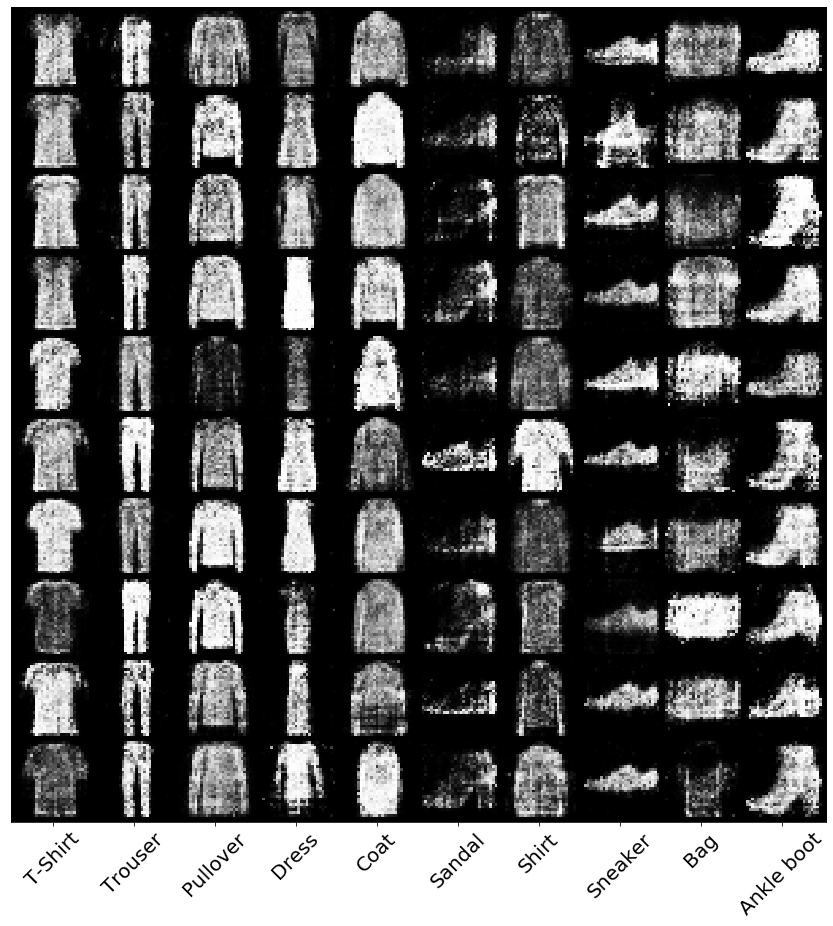

In [27]:
z = Variable(torch.randn(100, 100)).cuda()
labels = Variable(torch.LongTensor([i for _ in range(10) for i in range(10)])).cuda()
sample_images = generator(z, labels).unsqueeze(1).data.cpu()
grid = make_grid(sample_images, nrow=10, normalize=True).permute(1,2,0).numpy()
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(grid)
_ = plt.yticks([])
_ = plt.xticks(np.arange(15, 300, 30), ['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], rotation=45, fontsize=20)